# Individual Variability across cerebellum

In [51]:
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import seaborn as sb
import Functional_Fusion.dataset as ds
import ProbabilisticParcellation.util as ut
from copy import deepcopy
import ProbabilisticParcellation.learn_fusion_gpu as lf
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as sc
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.scripts.atlas_paper.symmetry as sm
import ProbabilisticParcellation.scripts.atlas_paper.describe_atlas as da
from PcmPy import indicator
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.evaluation as ev
import Functional_Fusion.atlas_map as am
import SUITPy as suit
import os
import ProbabilisticParcellation.scripts.atlas_paper.individual_variability as var
import nitools as nt
import nibabel as nb


In [2]:
figure_path = "/Users/jdiedrichsen/Dropbox (Diedrichsenlab)/papers/AtlasPaper/figure_parts/"
if not os.path.exists(figure_path):
    figure_path = "/Users/callithrix/Dropbox/AtlasPaper/figure_parts/"
atlas_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'


In [3]:
T = pd.read_csv(ut.base_dir + "/dataset_description.tsv", sep="\t")
Data, Info = [], []
for d, dname in enumerate(T.name[:-1]):
    data, info, dset = ds.get_dataset(ut.base_dir, dname, atlas="MNISymC2")
    Data.append(data)
    Info.append(info)

/Users/callithrix/code/Python/Functional_Fusion/dataset.py:467: UserWarning: sub-11, ses-preference, CondHalf - missing data painting_constant-half2
  warnings.warn(


In [4]:
# Get inter-individual variability for plotting
Corr, Corr_norm, Rel = var.calc_variability(Data, Info, subject_wise=False)

/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:173: RuntimeWarning: Mean of empty slice
  correlation = np.nanmean(
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:176: RuntimeWarning: Mean of empty slice
  noise_ceiling = np.nanmean(


In [75]:


def calc_variability(Data, Info, subject_wise=False):
    T = pd.read_csv(ut.base_dir + "/dataset_description.tsv", sep="\t")

    # Get inter-individual variability, normalize by geometric mean of reliabilities
    Corr, Corr_norm, Rel = [], [], []
    for d, dname in enumerate(T.name[:-1]):
        # Loop over voxels
        corr = []
        corr_norm = []
        rel = []
        for vox in np.arange(Data[0].shape[2]):
            data = Data[d][:, :, vox]
            correlation = np.corrcoef(data)

            # Get the reliability of each subject by correlating the first and second half
            half1 = data[:, Info[d].half == 1]
            half2 = data[:, Info[d].half == 2]
            reliabilites = []
            for sub in np.arange(half1.shape[0]):
                reliability = np.corrcoef(half1[sub, :], half2[sub, :])[0, 1]
                reliabilites.append(reliability)

            # Set negative reliability values to nan
            reliabilites = np.array(reliabilites)
            reliabilites[reliabilites <= 0] = np.nan
            rel.append(reliabilites)

            # Normalize by geometric mean of reliabilities
            if subject_wise:
                correlation[np.diag_indices(correlation.shape[0])] = np.nan
                noise_ceiling = np.sqrt(np.outer(reliabilites, reliabilites))
                corr_normalised = correlation / noise_ceiling
                # Append to list
                corr.append(np.nanmean(correlation, axis=0))
                corr_norm.append(np.nanmean(corr_normalised, axis=0))

            else:
                correlation = np.nanmean(
                    correlation[np.triu_indices(correlation.shape[0], k=1)]
                )
                noise_ceiling = np.nanmean(
                    np.sqrt(
                        np.outer(reliabilites, reliabilites)[
                            np.triu_indices(reliabilites.shape[0], k=1)
                        ]
                    )
                )
                corr_normalised = correlation / noise_ceiling
                # Append to list
                corr.append(correlation)
                corr_norm.append(corr_normalised)

        # Collect voxels for this dataset
        Corr.append(np.array(corr))
        Corr_norm.append(np.array(corr_norm))
        Rel.append(np.array(rel))

    return Corr, Corr_norm, Rel

In [6]:
T = pd.read_csv(ut.base_dir + "/dataset_description.tsv", sep="\t")
cscale = (0,1)
# Get atlas
suit_atlas, _ = am.get_atlas("MNISymC2", ut.base_dir + "/Atlases")

# Plot Variabilities

## MDTB

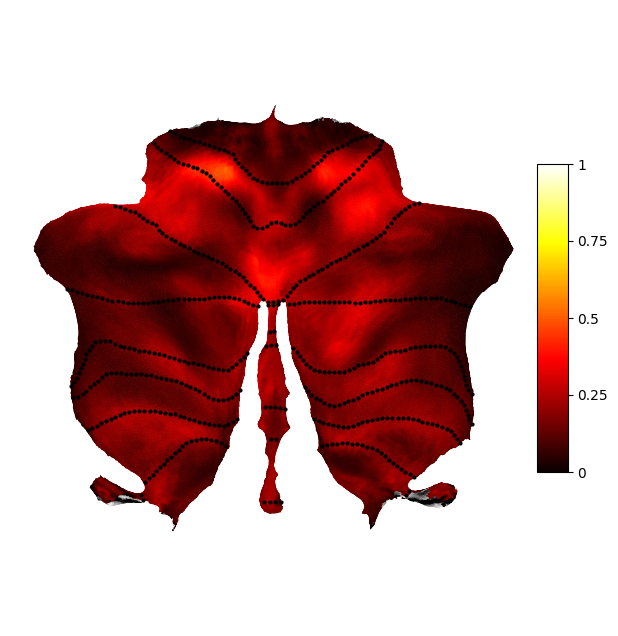

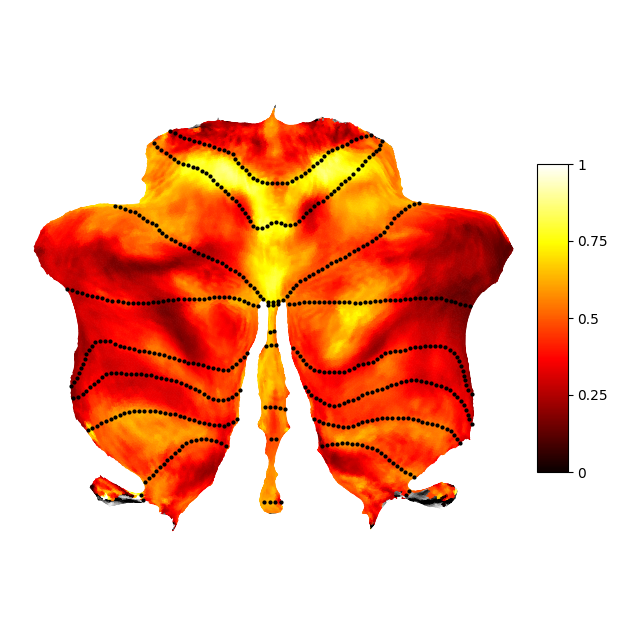

In [7]:
dataset = 'MDTB'
d = np.where([T.name == dataset])[0].item()

# Plot individual variability
Nifti = suit_atlas.data_to_nifti(Corr[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    cmap="hot",
    cscale=cscale,
    overlay_type="func",
    colorbar=True,
    bordersize=4,
)
filename = f"var_{dataset}"
plt.savefig(f"{figure_path}/individual_variability/{filename}.png", dpi=300, bbox_inches="tight")


# Plot normalized individual variability
Nifti = suit_atlas.data_to_nifti(Corr_norm[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    cmap="hot",
    cscale=cscale,
    overlay_type="func",
    colorbar=True,
    bordersize=4,
)
filename = f"var_norm_{dataset}_norm"
plt.savefig(f"{figure_path}/individual_variability/{filename}.png", dpi=300, bbox_inches="tight")

# Variability for all datasets

<AxesSubplot: title={'center': 'Somatotopic'}>

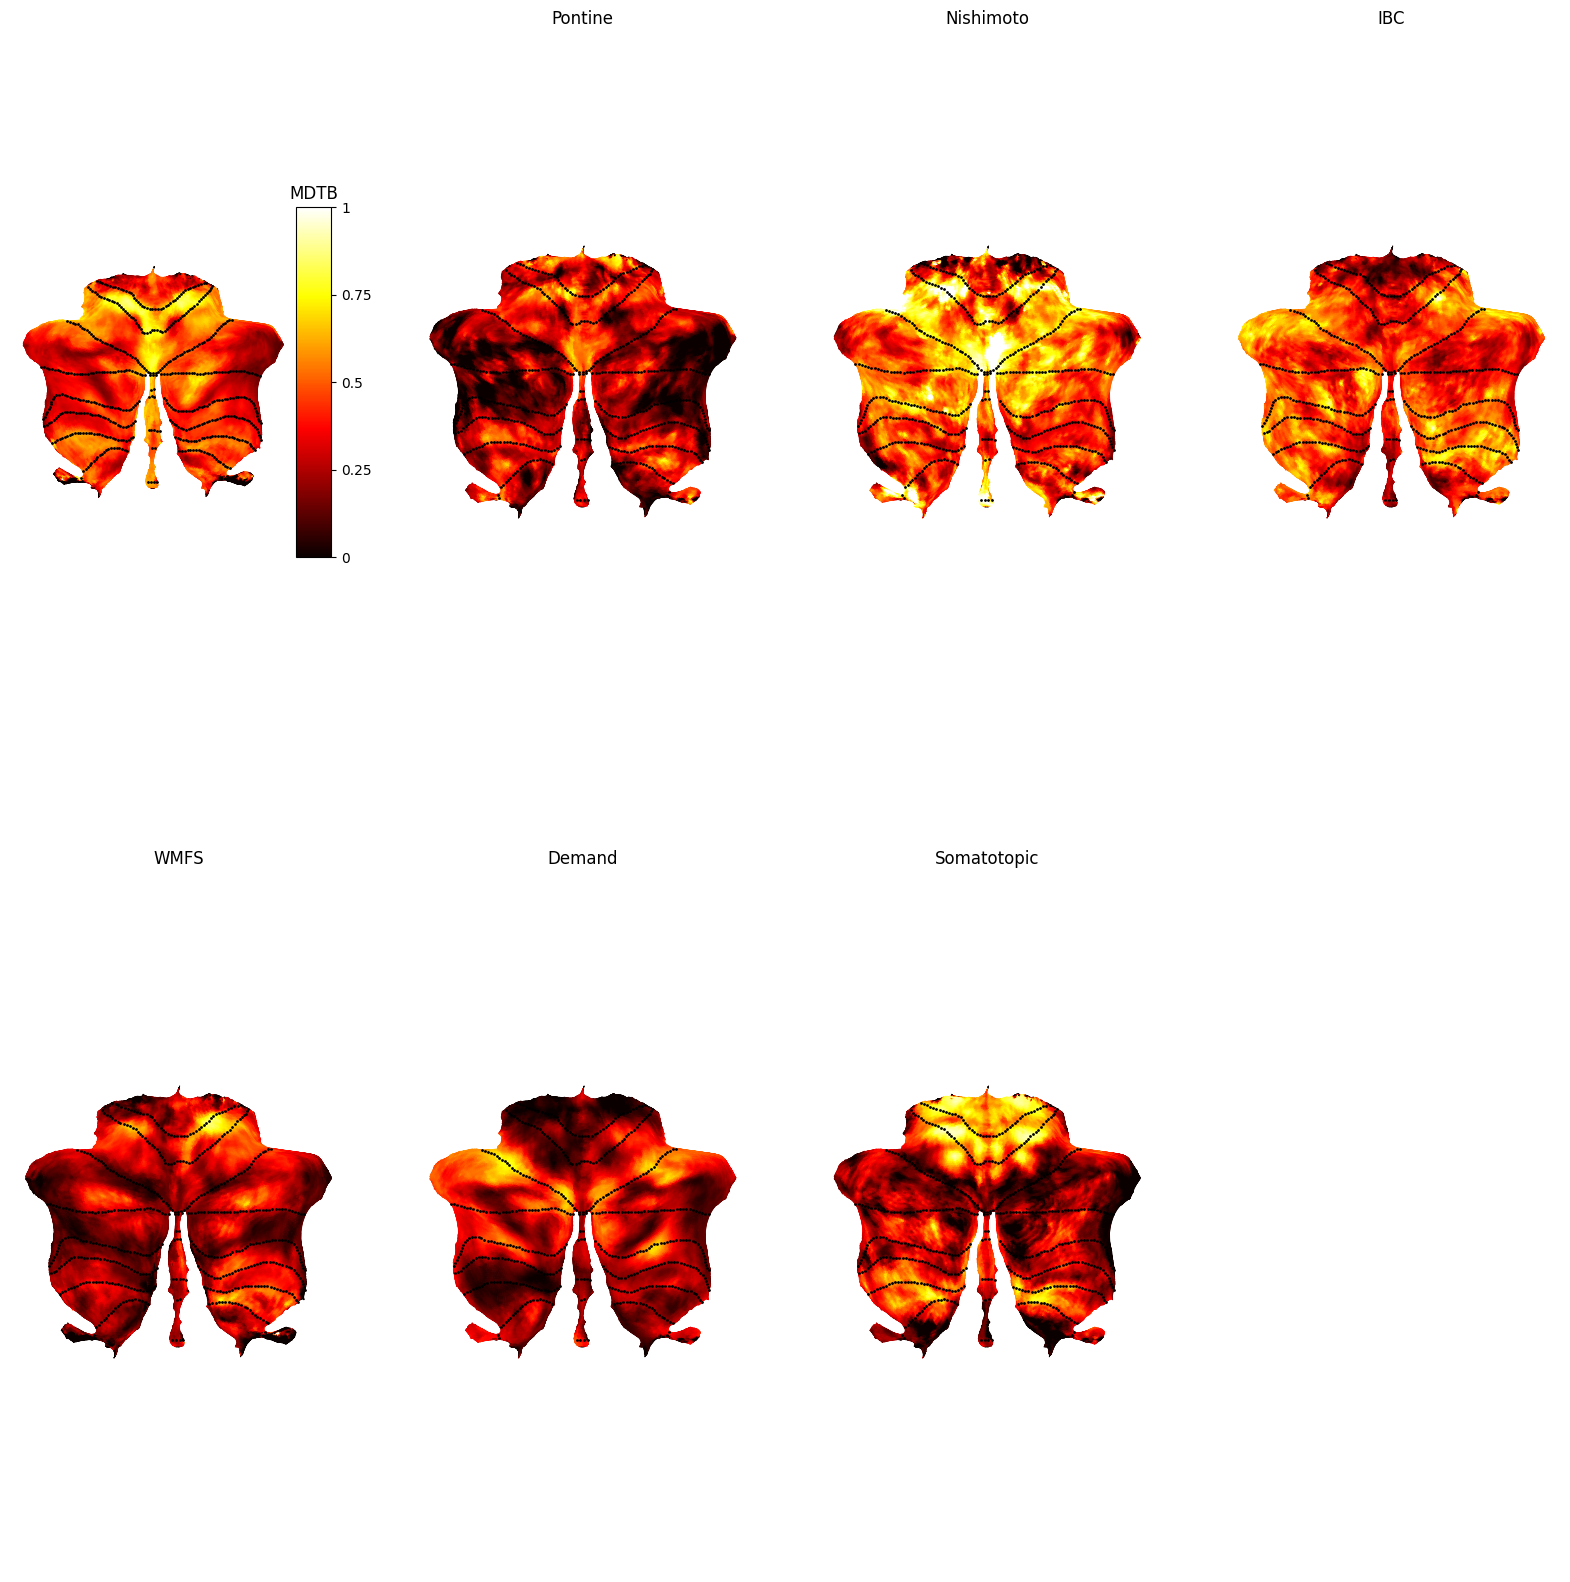

In [14]:
plt.figure(figsize=(20, 20))
ut.plot_multi_flat(Corr_norm, 'MNISymC2',
                   grid=(2, 4),
                   dtype='func',
                   colorbar=True,
                   cmap='hot',
                   cscale=cscale,
                   titles=T.name[:-1].values)

# Average across datasets

In [8]:
# Average Corr_norm values apart fron Nishimoto & IBC
exclude = ['Nishimoto', 'IBC']
Corr_norm_mean = np.nanmean([Corr_norm[i] for i in range(len(Corr_norm)) if T.name[i] not in exclude], axis=0)

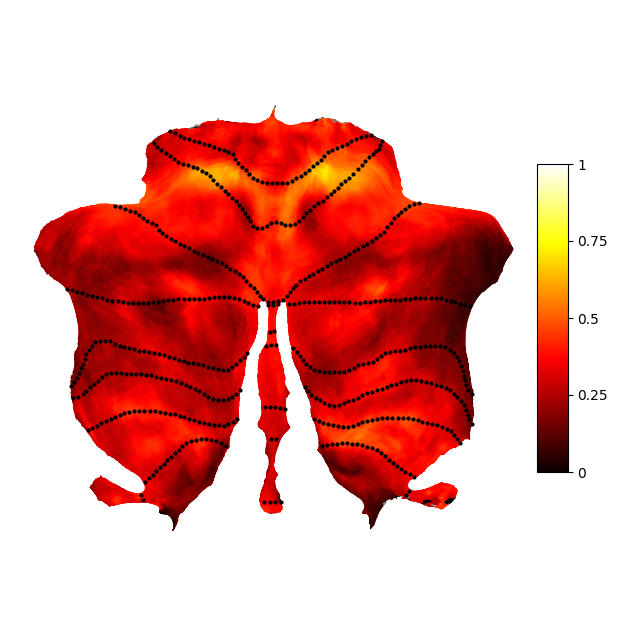

In [9]:
# Plot individual variability
Nifti = suit_atlas.data_to_nifti(Corr_norm_mean)
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    cmap="hot",
    cscale=cscale,
    overlay_type="func",
    colorbar=True,
    bordersize=4,
)
filename = f"var_all_norm"
plt.savefig(f"{figure_path}/individual_variability/{filename}.png", dpi=300, bbox_inches="tight")


# Variability projected into Parcels

In [90]:
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'

# --- Get 32 parcel ---
mname = 'Models_03/NettekovenSym32_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)
# Import labels
_, cmap, labels_32 = nt.read_lut(lut_dir +
                              f'{split_mn[0].split("_space")[0]}.lut')
labels_32=labels_32[1:]

# Get winner take-all
Prob = np.array(model.marginal_prob())
parcel_32 = Prob.argmax(axis=0) + 1

# --- Get 68 parcel ---
mname = 'Models_03/NettekovenSym68_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)
# Import labels
_, cmap, labels_68 = nt.read_lut(lut_dir +
                              f'{split_mn[0].split("_space")[0]}.lut')
labels_68=labels_68[1:]

# Get winner take-all
Prob = np.array(model.marginal_prob())
parcel_68 = Prob.argmax(axis=0) + 1

In [38]:
# Map the variability to the parcels   
Nifti = suit_atlas.data_to_nifti(parcel_32.astype(float))
surf_parcel_32 = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel_32 = np.nan_to_num(surf_parcel_32, copy=False).astype(int)

Nifti = suit_atlas.data_to_nifti(parcel_68.astype(float))
surf_parcel_68 = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel_68 = np.nan_to_num(surf_parcel_68, copy=False).astype(int)

## MDTB Variability

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/3338508395.py:7: RuntimeWarning: Mean of empty slice
  corr_map[mask] = np.nanmean(surf_data[mask])


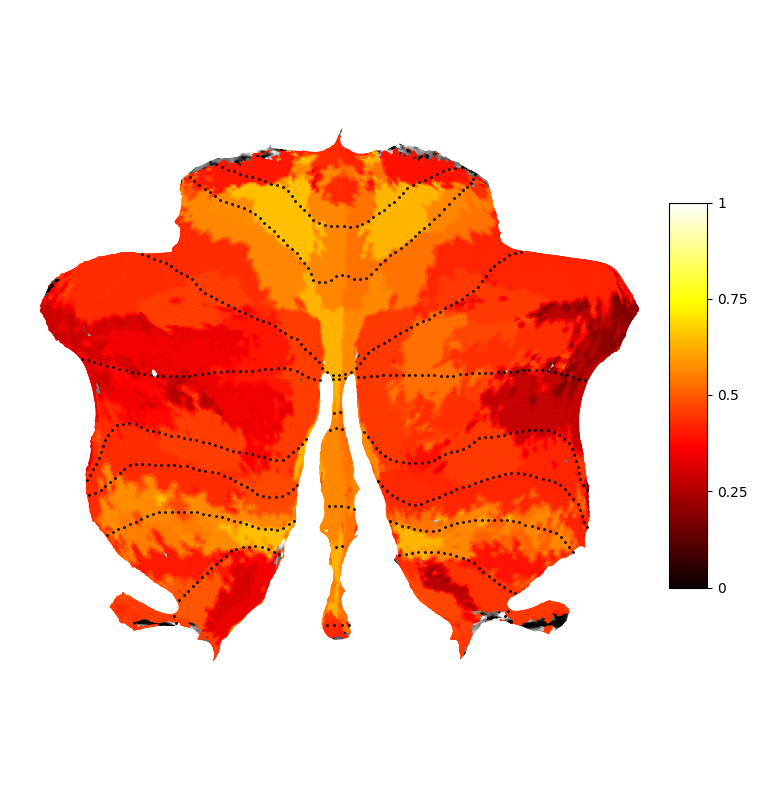

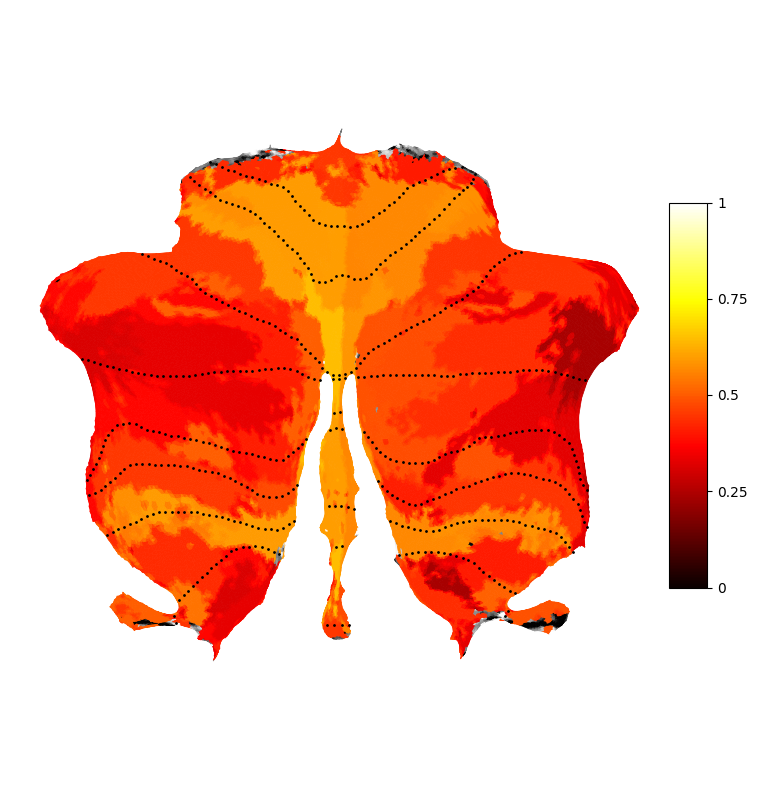

In [47]:
# Plot MDTB variability in K68
Nifti = suit_atlas.data_to_nifti(Corr_norm[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
corr_map = np.zeros(surf_parcel_68.shape) * np.nan
for p in np.arange(1,surf_parcel_68.max()+1):
    mask = (surf_parcel_68 == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=(5, 5))
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cmap='hot')
plt.savefig(figure_path + '/individual_variability/var_parcel_norm_68-mdtb.png',
            dpi=300, bbox_inches='tight')


# Plot MDTB variability in K32
corr_map = np.zeros(surf_parcel_32.shape) * np.nan
for p in np.arange(1,surf_parcel_32.max()+1):
    mask = (surf_parcel_32 == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=(5, 5))
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cscale=cscale,
                    cmap='hot')
plt.savefig(figure_path + '/individual_variability/var_parcel_norm_32-mdtb.png',
            dpi=300, bbox_inches='tight')



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/3701824381.py:6: RuntimeWarning: Mean of empty slice
  corr_map[mask] = np.nanmean(surf_data[mask])


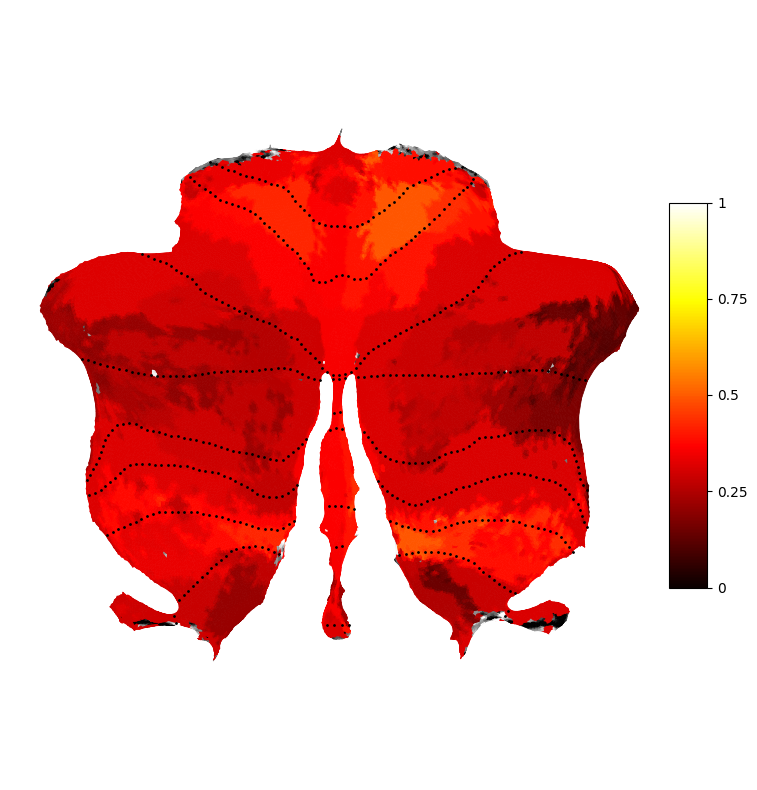

In [48]:
Nifti = suit_atlas.data_to_nifti(Corr_norm_mean)
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
corr_map = np.zeros(surf_parcel_68.shape) * np.nan
for p in np.arange(1,surf_parcel_68.max()+1):
    mask = (surf_parcel_68 == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=(5, 5))
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cscale=cscale,
                    cmap='hot')
plt.savefig(figure_path + '/individual_variability/var_parcel_norm_68-all.png',
            dpi=300, bbox_inches='tight')


# Stats

In [76]:
# Get inter-individual variability for statistics
Corr_subj, Corr_norm_subj, Rel_subj = calc_variability(Data, Info, subject_wise=True)

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/3419199527.py:35: RuntimeWarning: Mean of empty slice
  corr_norm.append(np.nanmean(corr_normalised, axis=0))
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/3419199527.py:34: RuntimeWarning: Mean of empty slice
  corr.append(np.nanmean(correlation, axis=0))


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/2767950514.py:1: RuntimeWarning: Mean of empty slice
  Nifti = suit_atlas.data_to_nifti(np.nanmean(Corr_norm_subj[0], axis=1))
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/2767950514.py:6: RuntimeWarning: Mean of empty slice
  corr_map[mask] = np.nanmean(surf_data[mask])


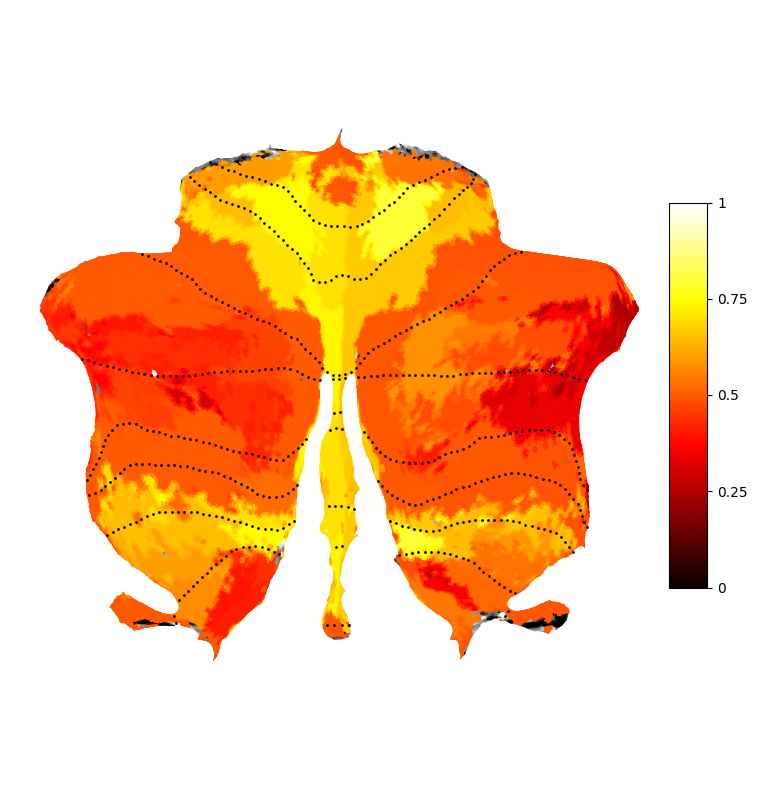

In [77]:
Nifti = suit_atlas.data_to_nifti(np.nanmean(Corr_norm_subj[0], axis=1))
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
corr_map = np.zeros(surf_parcel_68.shape) * np.nan
for p in np.arange(1,surf_parcel_68.max()+1):
    mask = (surf_parcel_68 == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=(5, 5))
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cscale=cscale,
                    cmap='hot')
plt.savefig(figure_path + '/individual_variability/var_parcel_norm_68-all.png',
            dpi=300, bbox_inches='tight')


In [144]:

# Project the individual variability onto the 32 parcel
parcel_matrix = indicator(parcel_32.squeeze())

corr_vals = []
for sub in range(Corr_norm_subj[0].shape[1]):
    sub_values = np.nansum(parcel_matrix.T*Corr_norm_subj[0][:, sub], axis=1)/parcel_matrix.shape[0]
    corr_vals.append(sub_values)

corr_vals = np.array(corr_vals).T

([<matplotlib.axis.XTick at 0x7ff32b19b790>,
 [Text(0, 0, 'M1L'),
  Text(1, 0, 'M2L'),
  Text(2, 0, 'M3L'),
  Text(3, 0, 'M4L'),
  Text(4, 0, 'A1L'),
  Text(5, 0, 'A2L'),
  Text(6, 0, 'A3L'),
  Text(7, 0, 'A4L'),
  Text(8, 0, 'D1L'),
  Text(9, 0, 'D2L'),
  Text(10, 0, 'D3L'),
  Text(11, 0, 'D4L'),
  Text(12, 0, 'S1L'),
  Text(13, 0, 'S2L'),
  Text(14, 0, 'S3L'),
  Text(15, 0, 'S4L'),
  Text(16, 0, 'M1R'),
  Text(17, 0, 'M2R'),
  Text(18, 0, 'M3R'),
  Text(19, 0, 'M4R'),
  Text(20, 0, 'A1R'),
  Text(21, 0, 'A2R'),
  Text(22, 0, 'A3R'),
  Text(23, 0, 'A4R'),
  Text(24, 0, 'D1R'),
  Text(25, 0, 'D2R'),
  Text(26, 0, 'D3R'),
  Text(27, 0, 'D4R'),
  Text(28, 0, 'S1R'),
  Text(29, 0, 'S2R'),
  Text(30, 0, 'S3R'),
  Text(31, 0, 'S4R')])

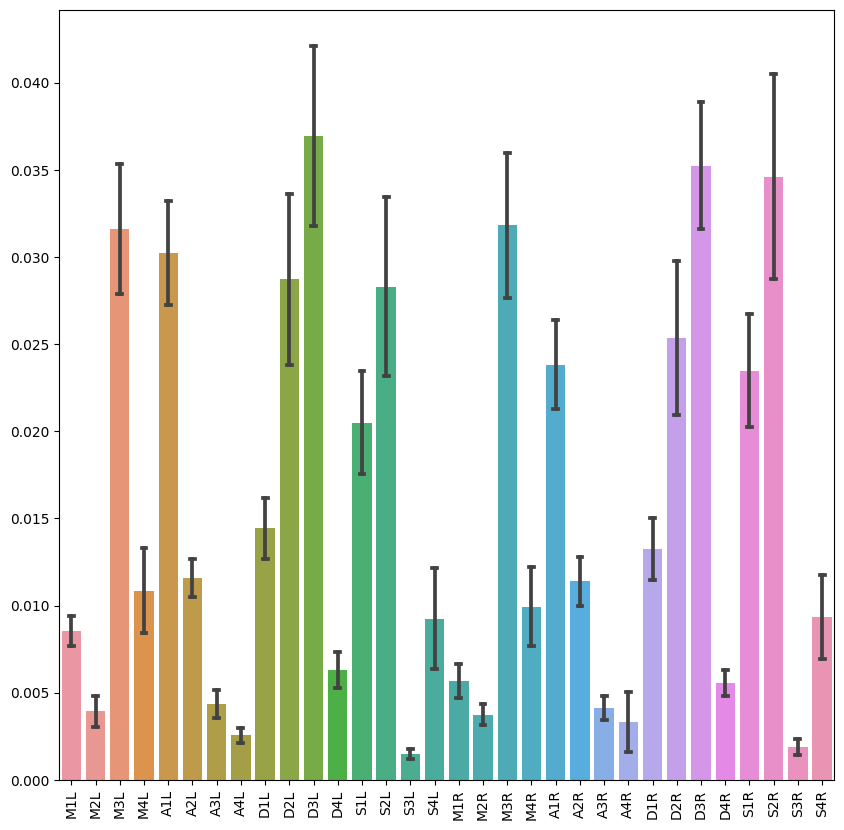

In [89]:
# seaborn barplot with second dimension of corr_vals on x-axis and errorbars
# with first dimension of corr_vals
plt.figure(figsize=(5, 5))
sb.barplot(data=corr_vals.T, errorbar='sd', capsize=.2)
plt.xticks(np.arange(32), labels_32, rotation=90)


In [145]:
# Make dataframe 
df = pd.DataFrame(corr_vals, columns=[f'sub-{sub}' for sub in range(corr_vals.shape[1])], index=labels_32)
df['Domain'] = df.index.str[:1]
# Melt to make the columns into a single column
df_melt = df.melt(var_name='Subject', value_name='Correlation', ignore_index=False, id_vars='Domain')

<AxesSubplot: xlabel='Domain', ylabel='Correlation'>

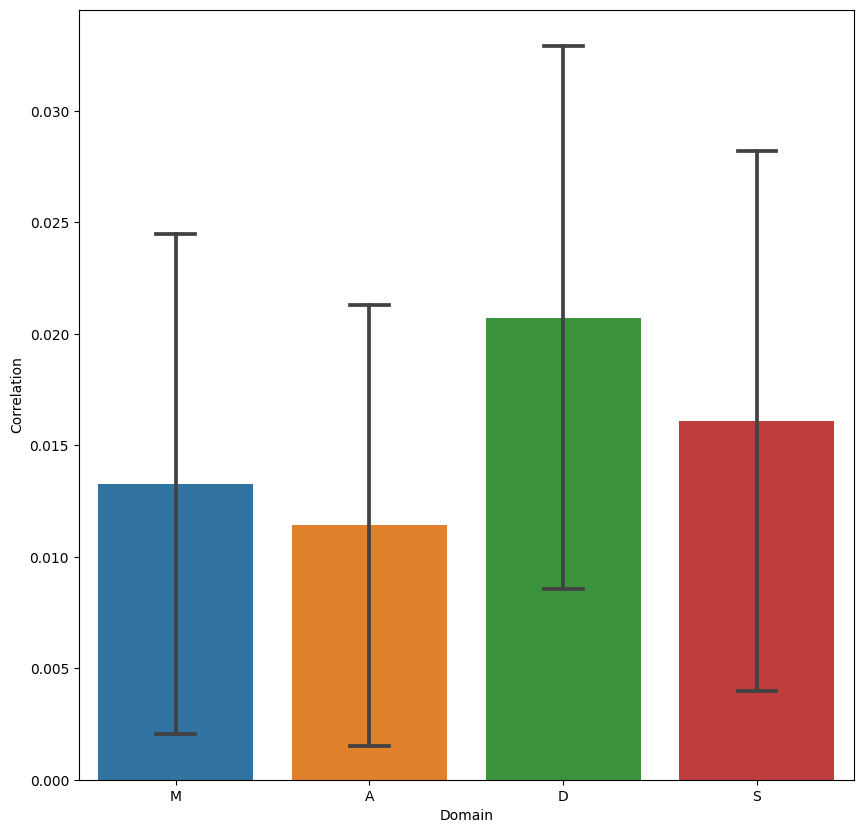

In [146]:
# Plot the dataframe
plt.figure(figsize=(5, 5))
sb.barplot(data=df_melt, capsize=.2, errorbar='sd', x='Domain', y='Correlation')


Ttest_relResult(statistic=-19.47685900630977, pvalue=8.61073017210578e-16)

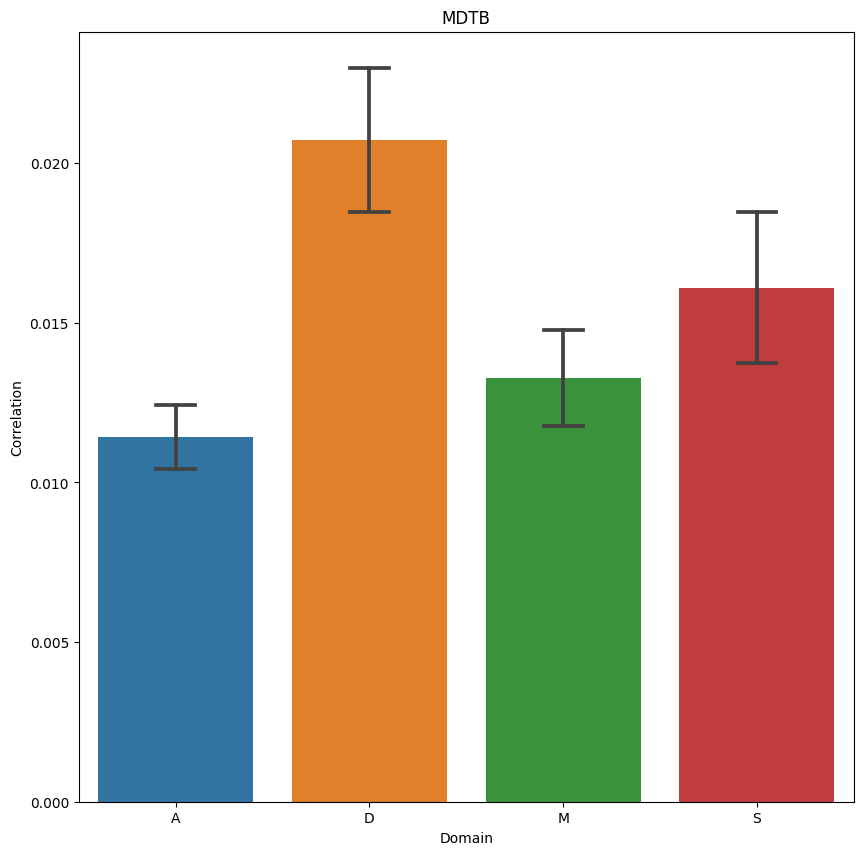

In [147]:
# Run paired t-test to test for correlation value difference between domains
from scipy.stats import ttest_rel
# Get mean value for each subject's domain
df_domain = df_melt.groupby(['Subject', 'Domain']).mean().reset_index()
# Plot the dataframe
plt.figure(figsize=(5, 5))
sb.barplot(data=df_domain, capsize=.2, errorbar='sd', x='Domain', y='Correlation')
plt.title('MDTB')

ttest_rel(df_domain[df_domain['Domain'] == 'M']['Correlation'], df_domain[df_domain['Domain'] == 'S']['Correlation'])
ttest_rel(df_domain[df_domain['Domain'] == 'M']['Correlation'], df_domain[df_domain['Domain'] == 'D']['Correlation'])

## Test for Demand

Ttest_relResult(statistic=-45.66943306780049, pvalue=1.8089907404260825e-33)

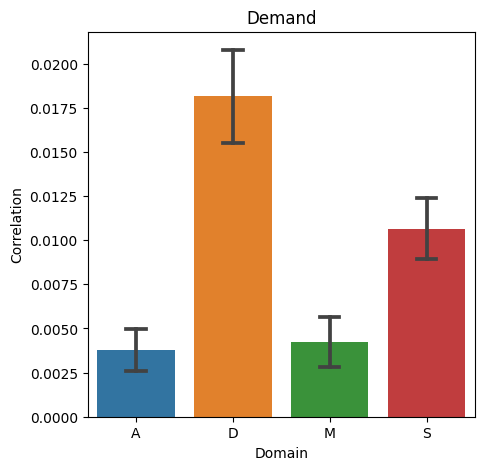

In [152]:
dataset = 'Demand'
d = np.where([T.name == dataset])[1].item()
# Project the individual variability onto the 32 parcel
parcel_matrix = indicator(parcel_32.squeeze())

corr_vals = []
for sub in range(Corr_norm_subj[d].shape[1]):
    sub_values = np.nansum(parcel_matrix.T*Corr_norm_subj[d][:, sub], axis=1)/parcel_matrix.shape[0]
    corr_vals.append(sub_values)

corr_vals = np.array(corr_vals).T

# Make dataframe 
df = pd.DataFrame(corr_vals, columns=[f'sub-{sub}' for sub in range(corr_vals.shape[1])], index=labels_32)
df['Domain'] = df.index.str[:1]
# Melt to make the columns into a single column
df_melt = df.melt(var_name='Subject', value_name='Correlation', ignore_index=False, id_vars='Domain')

# Get mean value for each subject's domain
df_domain = df_melt.groupby(['Subject', 'Domain']).mean().reset_index()
# Plot the dataframe
plt.figure(figsize=(5, 5))
sb.barplot(data=df_domain, capsize=.2, errorbar='sd', x='Domain', y='Correlation')
plt.title(dataset)

ttest_rel(df_domain[df_domain['Domain'] == 'M']['Correlation'], df_domain[df_domain['Domain'] == 'S']['Correlation'])
ttest_rel(df_domain[df_domain['Domain'] == 'M']['Correlation'], df_domain[df_domain['Domain'] == 'D']['Correlation'])

Ttest_relResult(statistic=0.5763082420581908, pvalue=0.5824545640425645)

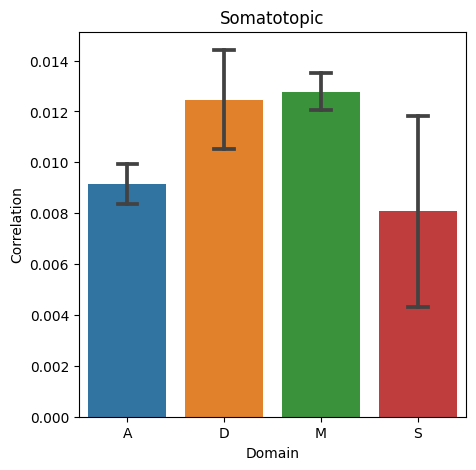

In [153]:
dataset = 'Somatotopic'
d = np.where([T.name == dataset])[1].item()
# Project the individual variability onto the 32 parcel
parcel_matrix = indicator(parcel_32.squeeze())

corr_vals = []
for sub in range(Corr_norm_subj[d].shape[1]):
    sub_values = np.nansum(parcel_matrix.T*Corr_norm_subj[d][:, sub], axis=1)/parcel_matrix.shape[0]
    corr_vals.append(sub_values)

corr_vals = np.array(corr_vals).T

# Make dataframe 
df = pd.DataFrame(corr_vals, columns=[f'sub-{sub}' for sub in range(corr_vals.shape[1])], index=labels_32)
df['Domain'] = df.index.str[:1]
# Melt to make the columns into a single column
df_melt = df.melt(var_name='Subject', value_name='Correlation', ignore_index=False, id_vars='Domain')

# Get mean value for each subject's domain
df_domain = df_melt.groupby(['Subject', 'Domain']).mean().reset_index()
# Plot the dataframe
plt.figure(figsize=(5, 5))
sb.barplot(data=df_domain, capsize=.2, errorbar='sd', x='Domain', y='Correlation')
plt.title(dataset)

ttest_rel(df_domain[df_domain['Domain'] == 'M']['Correlation'], df_domain[df_domain['Domain'] == 'S']['Correlation'])
ttest_rel(df_domain[df_domain['Domain'] == 'M']['Correlation'], df_domain[df_domain['Domain'] == 'D']['Correlation'])